# Swish-based ensemble with categorical entity embedding
- SWish activation, 4 layers, 100 neurons per layer
- PRI_jet_num embedded
- Train-time/test-time data augmentation
- linear cycle LR
- FGE
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [1]:
from __future__ import division
import sys
import os
sys.path.append('../../')
from modules.basics import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
NAME = '8_swish_ensemble_embed_aug_fge'

In [3]:
experiment = Experiment(NAME, 'helios_cuda', RESULTS_PATH)

In [4]:
!python ../../modules/data_import.py -d ../../data/ -f PRI_jet_num -s {experiment.seed}

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Converting to use_cartesian coordinates
Converting to use_cartesian coordinates
Training on 200000 datapoints and validating on 50000, using 31 feats:
['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_met_px', 'PRI_met_py', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI

## Training

### Import data

In [5]:
train_fy = HEPAugFoldYielder(DATA_PATH/'train.hdf5', rot_mult=2)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


In [6]:
train_feats = train_fy.cont_feats+train_fy.cat_feats

/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


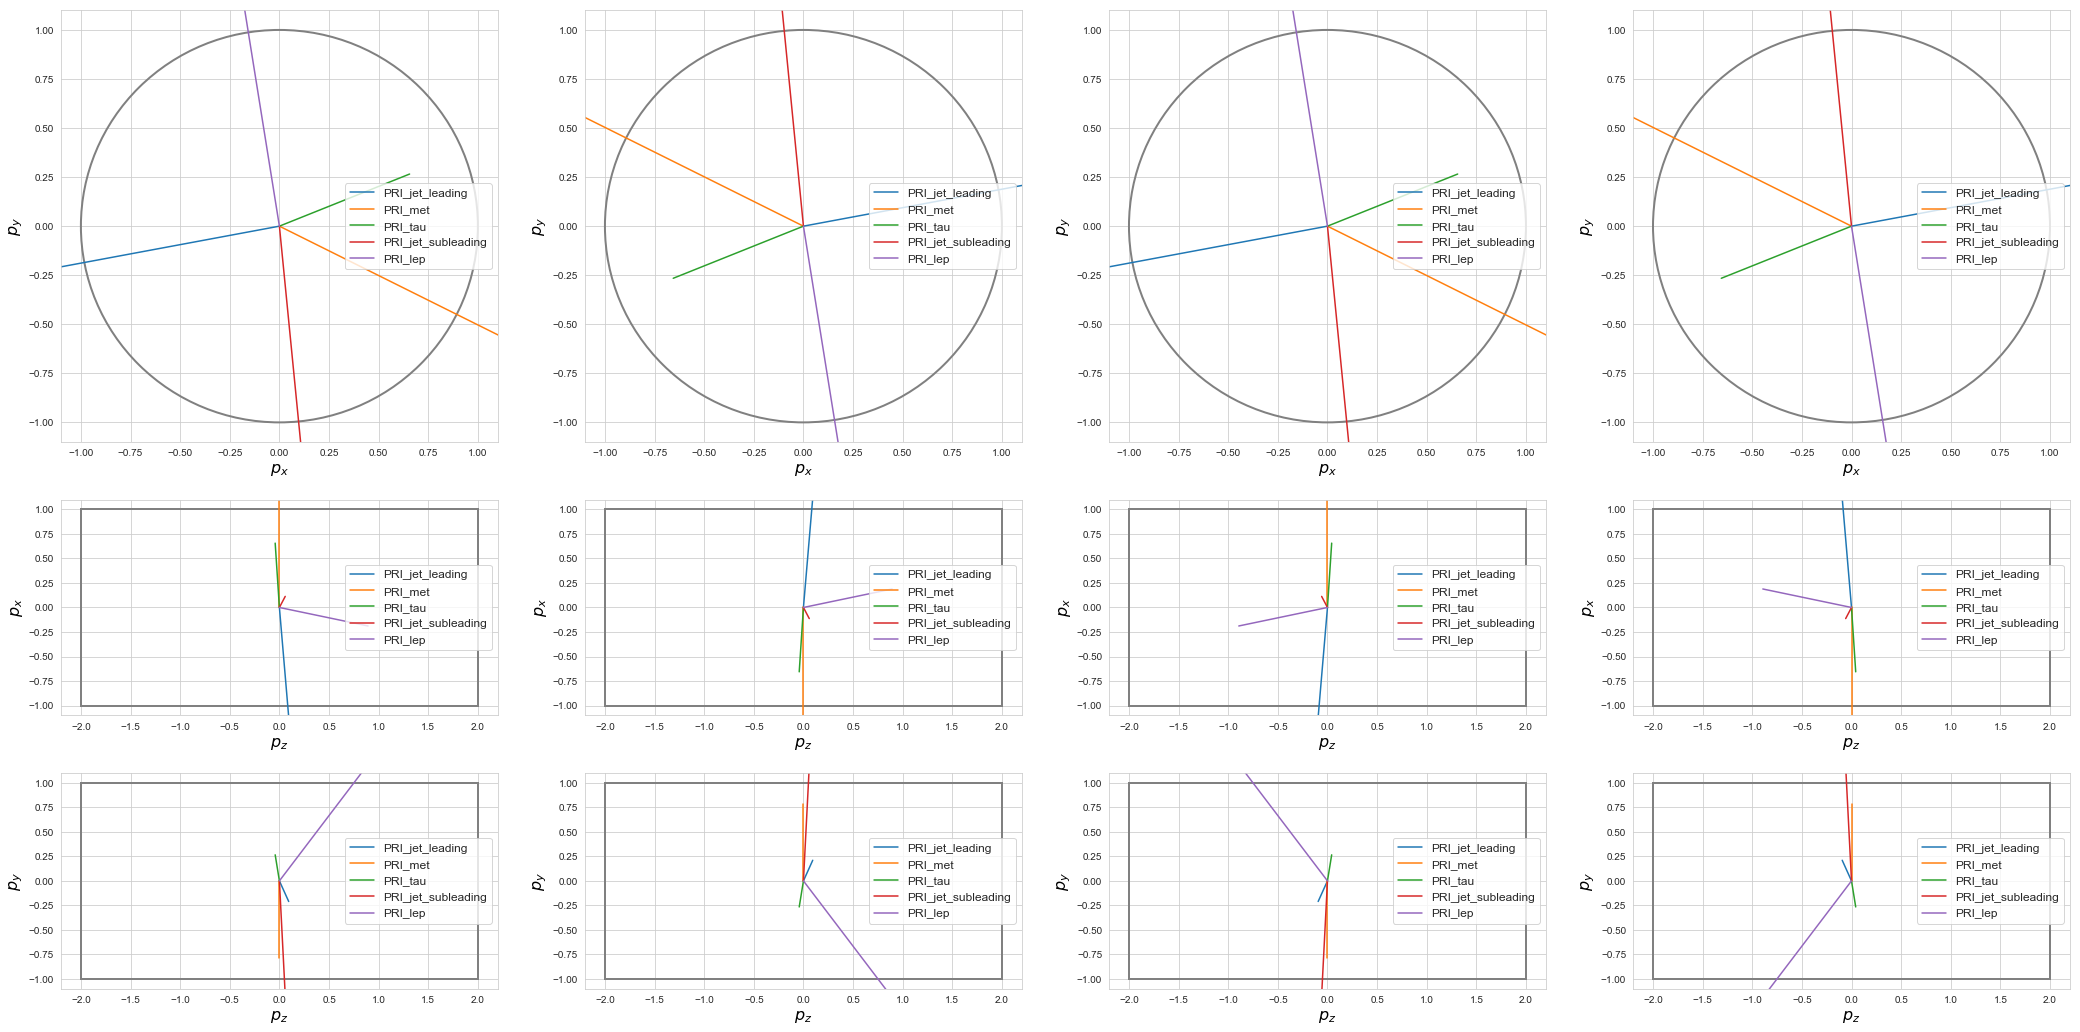

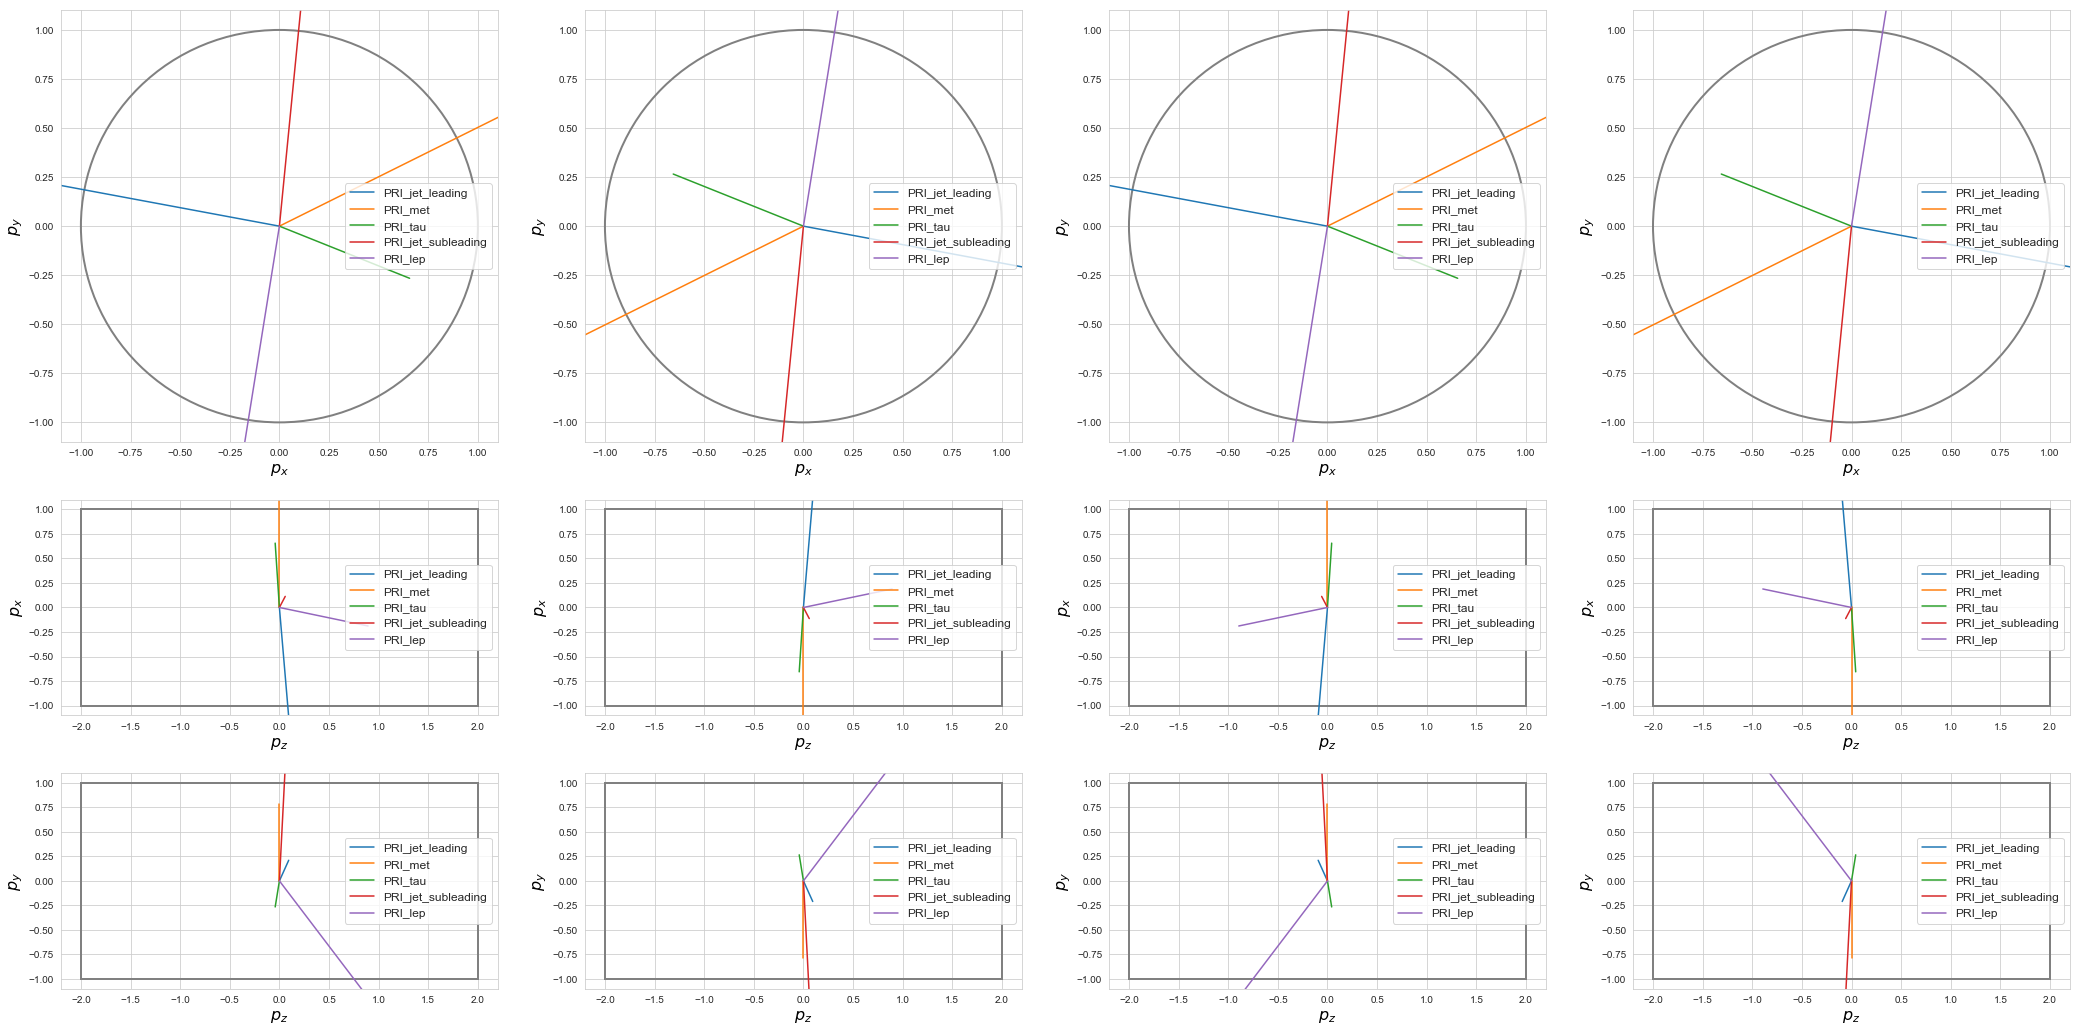

In [7]:
id=3
aug_ranges = [range(4), range(4,8)]
for aug_range in aug_ranges:
    compare_events([pd.DataFrame(train_fy.get_test_fold(0, i)['inputs'], columns=train_feats)[id:id+1] for i in aug_range])

/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


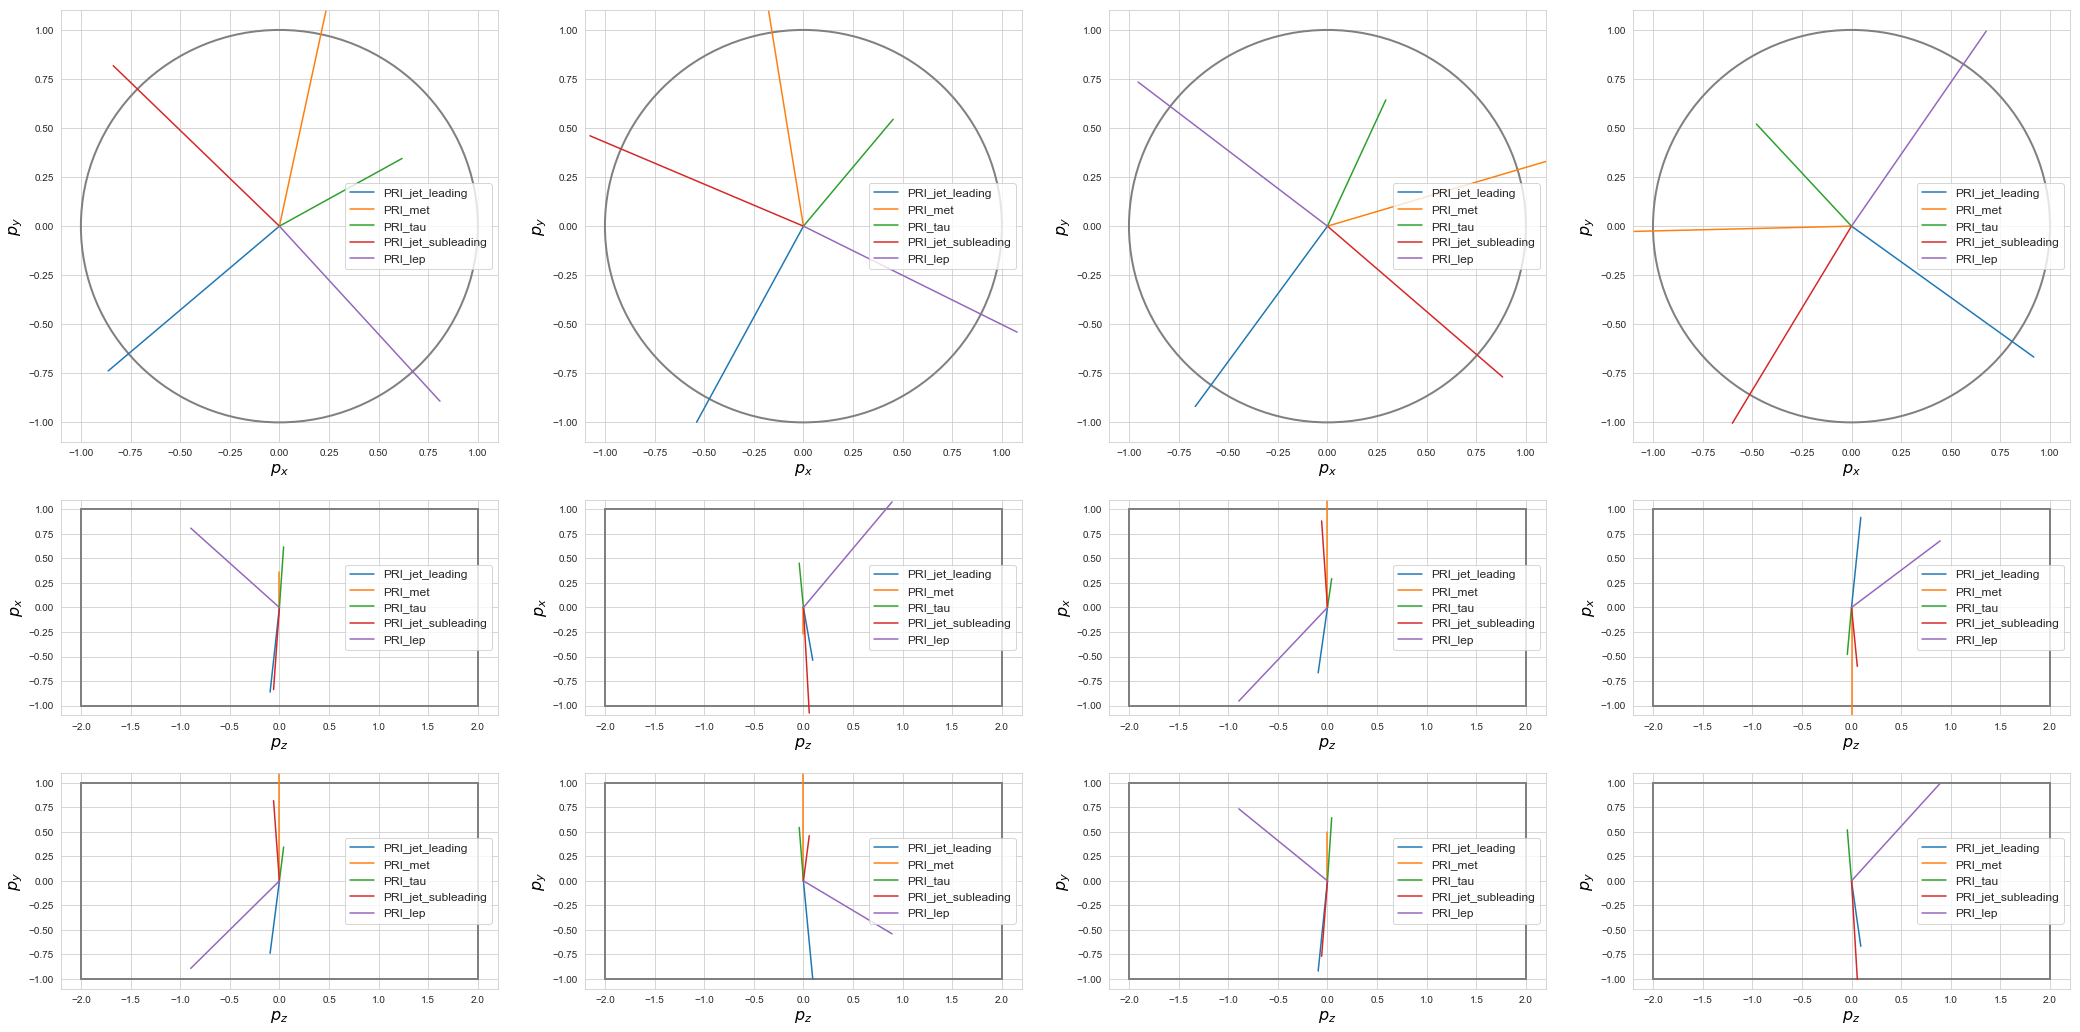

In [8]:
id=3
compare_events([pd.DataFrame(train_fy.get_fold(0)['inputs'], columns=train_feats)[id:id+1] for i in range(4)])

### Options

In [9]:
n_models = 10
patience = 10
max_epochs = 200
ensemble_size = 10


bs = 256
objective = 'classification'
model_args = {'body':{'act':'swish', 'width':100, 'depth':4}}
opt_args = {'opt':'adam', 'eps':1e-08}
cat_embedder = CatEmbedder.from_fy(train_fy, emb_szs=[3])

n_out = 1
model_builder = ModelBuilder(objective, cont_feats=train_fy.cont_feats, n_out=n_out, cat_embedder=cat_embedder,
                             model_args=model_args, opt_args=opt_args)
Model(model_builder)

Inputs:
30 Continuous: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_sumet', 'PRI_jet_all_pt', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_met_px', 'PRI_met_py', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_met_pt']
                   
1  Categorical: ['PRI_jet_num']
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): CatEmbHead(
    (embeds): ModuleList(
      (0): Embedding(4, 3)
    )
  )
  (1): FullyConnected(
    (layers): Sequential(
      (0): Sequential(
        (0): Linear(in_features=33, out_features=100, bias=True)
        (1): Swis

### Determine LR

LR finder took 3.760s 


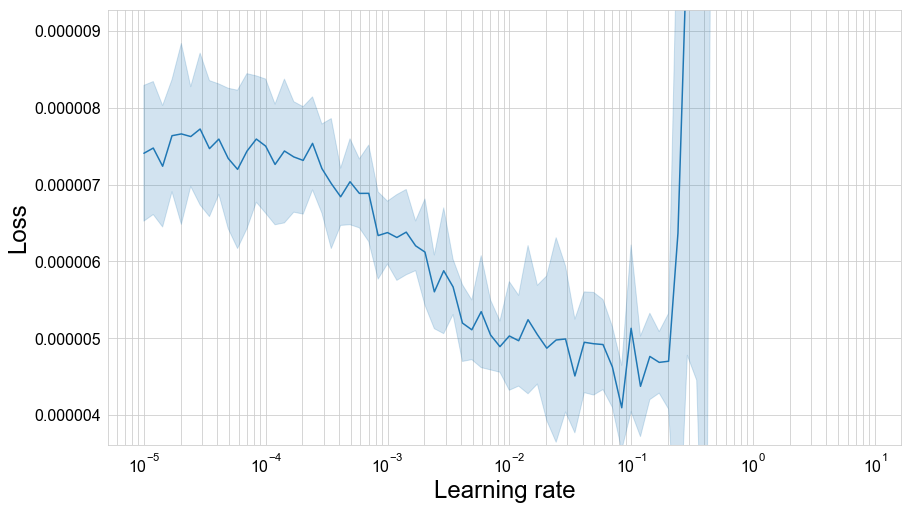

In [10]:
lr_finder = fold_lr_find(train_fy, model_builder, 256, lr_bounds=[1e-5,1e1])

### Train classifier

In [11]:
callback_partials = [partial(CycleLR, lr_range=(2e-4, 2e-3), cycle_mult=1 ,scale=5, interp='linear')]
eval_metrics = {'AMS':AMS(n_total=250000, br=10, wgt_name='gen_weight_original')}

Training model 1 / 10, Val ID = 0


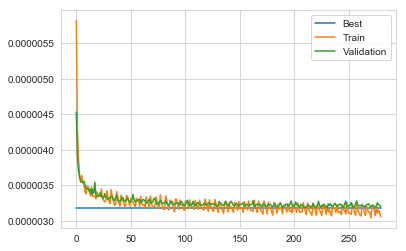

Early stopping after 280 epochs
Scores are: {'loss': 3.1815486636332935e-06, 'AMS': 3.699639729527827}
Fold took 128.896s

Training model 2 / 10, Val ID = 1


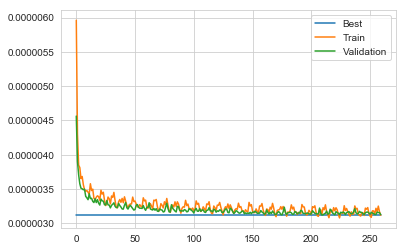

Early stopping after 260 epochs
Scores are: {'loss': 3.120096380371251e-06, 'AMS': 4.788291244406958}
Fold took 114.520s

Training model 3 / 10, Val ID = 2


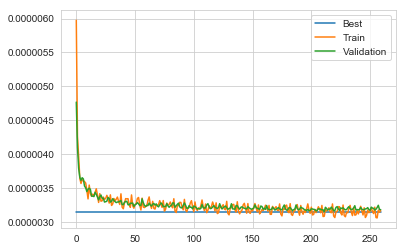

Early stopping after 260 epochs
Scores are: {'loss': 3.1518541163677583e-06, 'AMS': 4.245978933609351}
Fold took 115.773s

Training model 4 / 10, Val ID = 3


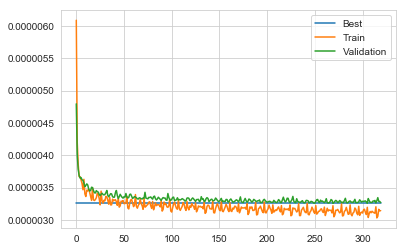

Early stopping after 320 epochs
Scores are: {'loss': 3.2556604310229886e-06, 'AMS': 3.4904555265312713}
Fold took 140.212s

Training model 5 / 10, Val ID = 4


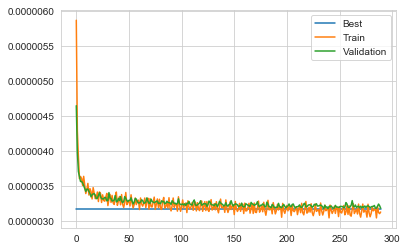

Early stopping after 290 epochs
Scores are: {'loss': 3.1829665658733575e-06, 'AMS': 3.7224027350487177}
Fold took 129.030s

Training model 6 / 10, Val ID = 5


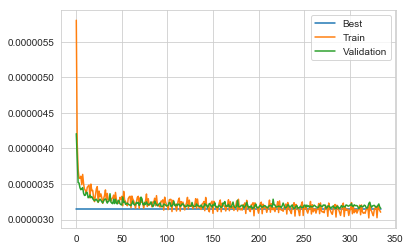

Early stopping after 335 epochs
Scores are: {'loss': 3.1539609608444152e-06, 'AMS': 4.216031892433505}
Fold took 147.110s

Training model 7 / 10, Val ID = 6


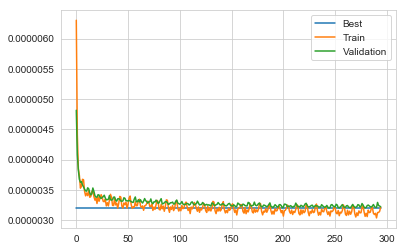

Early stopping after 295 epochs
Scores are: {'loss': 3.2009577353164786e-06, 'AMS': 3.9821189466213225}
Fold took 128.562s

Training model 8 / 10, Val ID = 7


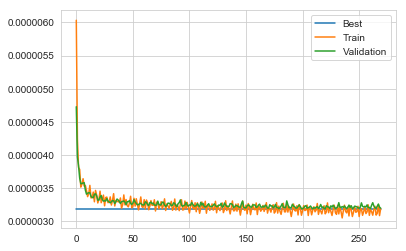

Early stopping after 270 epochs
Scores are: {'loss': 3.184539764333749e-06, 'AMS': 3.841170439518235}
Fold took 116.977s

Training model 9 / 10, Val ID = 8


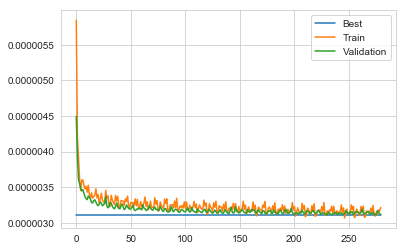

Early stopping after 280 epochs
Scores are: {'loss': 3.1134070468397113e-06, 'AMS': 3.8646399247982988}
Fold took 120.573s

Training model 10 / 10, Val ID = 9


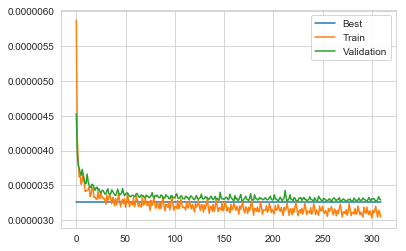

Early stopping after 310 epochs
Scores are: {'loss': 3.264469114583335e-06, 'AMS': 3.9829004375061254}
Fold took 137.210s


______________________________________
Training finished
Cross-validation took 1278.867s 


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

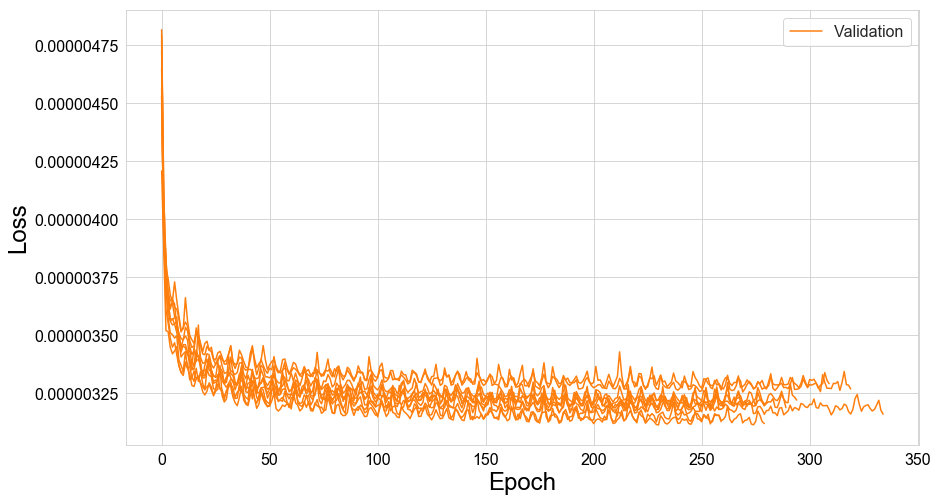

Mean loss = 3.18e-06±2e-08
Mean AMS = 4.0±0.1
______________________________________



In [12]:
train_timer = timeit.default_timer()
results, histories, cycle_losses = fold_train_ensemble(train_fy, n_models,
                                                       model_builder=model_builder,
                                                       bs=bs,
                                                       callback_partials=callback_partials,
                                                       eval_metrics=eval_metrics,
                                                       max_epochs=max_epochs, patience=patience)
train_time = timeit.default_timer()-train_timer
experiment['train_time'] = train_time

## Inference

### Construct ensemble

In [13]:
with open('train_weights/results_file.pkl', 'rb') as fin:   
    results = pickle.load(fin)
with open('train_weights/cycle_file.pkl', 'rb') as fin:   
    cycle_losses = pickle.load(fin)

In [14]:
snapshot_args = {'cycle_losses': cycle_losses, 'patience':patience,
                 'n_cycles':8, 'load_cycles_only':0, 'weighting_pwr':0}
ensemble = Ensemble.from_results(results, ensemble_size, model_builder, snapshot_args=snapshot_args, metric='loss', higher_metric_better=False)

Choosing ensemble by loss


/home/giles/cernbox/lumin/lumin/nn/ensemble/ensemble.py:221: UserWarning: Warning: Setting model weighting to uniform
  warnings.warn("Warning: Setting model weighting to uniform")


Model 0 is 8 with loss = 3.1134070468397113e-06
Model 0 cycle 45 has loss = 3.1213523925543996e-06 and weight 1
Model 0 cycle 44 has loss = 3.1337517611973453e-06 and weight 1
Model 0 cycle 43 has loss = 3.130980985588394e-06 and weight 1
Model 0 cycle 42 has loss = 3.1289703201764496e-06 and weight 1
Model 0 cycle 41 has loss = 3.1262002266885247e-06 and weight 1
Model 0 cycle 40 has loss = 3.134386133751832e-06 and weight 1
Model 0 cycle 39 has loss = 3.132547135464847e-06 and weight 1
Model 0 cycle 38 has loss = 3.1295232929551275e-06 and weight 1
Model 1 is 1 with loss = 3.120096380371251e-06
Model 1 cycle 41 has loss = 3.139931550322217e-06 and weight 1
Model 1 cycle 40 has loss = 3.1335450785263674e-06 and weight 1
Model 1 cycle 39 has loss = 3.1439408303413074e-06 and weight 1
Model 1 cycle 38 has loss = 3.1493964343098924e-06 and weight 1
Model 1 cycle 37 has loss = 3.129440528937266e-06 and weight 1
Model 1 cycle 36 has loss = 3.128714524791576e-06 and weight 1
Model 1 cycle 3

### Validation

#### Response on validation data without TTA

In [15]:
val_fy = FoldYielder(DATA_PATH/'val.hdf5')

In [16]:
val_timer = timeit.default_timer()
ensemble.predict(val_fy)
val_time = timeit.default_timer()-val_timer
experiment['val_time_no_tta'] = val_time

Mean time per event = 1.32e-05±2e-07


In [17]:
val_df = val_fy.get_df()

50000 datapoints loaded


Mean cut at 0.9421173930168152 corresponds to AMS of 3.719972998023527
Maximum AMS for data is 3.7450468733822575 at cut of 0.9451665878295898


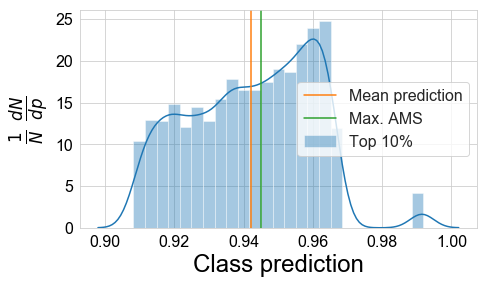

In [18]:
cut, experiment['val_ams_smooth_no_tta'], experiment['val_ams_max_no_tta'] = binary_class_cut_by_ams(val_df, top_perc=10, br=10, wgt_factor=250000/50000)

#### Response on validation data with TTA

In [19]:
val_fy = HEPAugFoldYielder(DATA_PATH/'val.hdf5', rot_mult=2)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


In [20]:
val_timer = timeit.default_timer()
ensemble.predict(val_fy, pred_name='pred_tta')
val_time = timeit.default_timer()-val_timer
experiment['val_time'] = val_time

Mean time per event = 0.000199±1e-06


In [21]:
val_df = val_fy.get_df(pred_name='pred_tta')

50000 datapoints loaded


Mean cut at 0.9417943358421326 corresponds to AMS of 3.721203144624791
Maximum AMS for data is 3.75915430904811 at cut of 0.9447097182273865


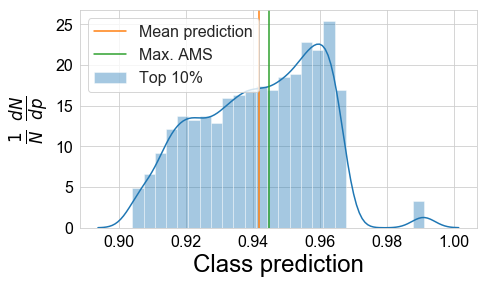

In [22]:
cut_tta, experiment['val_ams_smooth'], experiment['val_ams_max'] = binary_class_cut_by_ams(val_df, top_perc=10, br=10, wgt_factor=250000/50000)

### Testing

#### Test scoring without TTA

In [23]:
test_fy = FoldYielder(DATA_PATH/'test.hdf5')

In [24]:
test_timer = timeit.default_timer()
ensemble.predict(test_fy)
test_time = timeit.default_timer()-test_timer
experiment['test_time_no_tta'] = test_time

Mean time per event = 6.39e-06±5e-08


In [25]:
experiment['test_public_ams_mean_no_tta'], experiment['test_private_ams_mean_no_tta'] = score_test_data_per_fold(test_fy, cut, pred_name='pred')

Mean Public:Private AMS: 3.77±0.06 : 3.76±0.04


In [26]:
experiment['test_public_ams_no_tta'], experiment['test_private_ams_no_tta'] = score_test_data(test_fy, cut, pred_name='pred')

Public:Private AMS: 3.753755683483895 : 3.7591059321281133


#### Test scoring with TTA

In [27]:
test_fy = HEPAugFoldYielder(DATA_PATH/'test.hdf5', rot_mult=2)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


In [28]:
test_timer = timeit.default_timer()
ensemble.predict(test_fy, pred_name='pred_tta')
test_time = timeit.default_timer()-test_timer
experiment['test_time'] = test_time

Mean time per event = 0.000115±1e-06


In [29]:
experiment['test_public_ams_mean'], experiment['test_private_ams_mean'] = score_test_data_per_fold(test_fy, cut_tta, pred_name='pred_tta')

Mean Public:Private AMS: 3.75±0.07 : 3.76±0.03


In [30]:
experiment['test_public_ams'], experiment['test_private_ams'] = score_test_data(test_fy, cut_tta, pred_name='pred_tta')

Public:Private AMS: 3.738786470279079 : 3.761232929973479


## Results 

In [31]:
experiment

Experiment:	8_swish_ensemble_embed_aug_fge
Machine:	helios_cuda
Device:	Nvidia GeForce GTX 1080 Ti GPU
train_time	1279.3318059599987
val_time_no_tta	0.6676352569993469
val_ams_smooth_no_tta	3.719972998023527
val_ams_max_no_tta	3.7450468733822575
val_time	9.973275588999968
val_ams_smooth	3.721203144624791
val_ams_max	3.75915430904811
test_time_no_tta	3.5274930899995525
test_public_ams_mean_no_tta	(3.765413283420834, 0.06492974711987046)
test_private_ams_mean_no_tta	(3.762570146153814, 0.03772481860943038)
test_public_ams_no_tta	3.753755683483895
test_private_ams_no_tta	3.7591059321281133
test_time	63.050680890000876
test_public_ams_mean	(3.751465112663438, 0.06685344083691934)
test_private_ams_mean	(3.764230845085115, 0.03428165171064569)
test_public_ams	3.738786470279079
test_private_ams	3.761232929973479

In [32]:
experiment.save()